In [396]:
import pandas as pd
import numpy as np

In [397]:
df = pd.read_csv('./output/data/features.csv')

In [398]:
df.columns

Index(['file_path', 'sampling_rate', 'label', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'zcr_mean',
       'spectral_contrast_1_mean', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_contrast_6_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'lpc_1_mean', 'lpc_2_mean', 'lpc_3_mean',
       'lpc_4_mean', 'lpc_5_mean', 'lpc_6_mean', 'lpc_7_mean', 'lpc_8_mean',
       'lpc_9_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean'],
      dtype='object')

In [399]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,label,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,lpc_3_mean,lpc_4_mean,lpc_5_mean,lpc_6_mean,lpc_7_mean,lpc_8_mean,lpc_9_mean,lpc_10_mean,lpc_11_mean,lpc_12_mean
0,0,-392.408060,122.706493,4.529471,-1.131724,10.133050,-7.359573,-12.236763,-11.748826,-14.925097,...,0.206947,0.242434,0.083058,-0.000745,0.017267,0.048853,0.049655,0.011606,-0.013775,0.056669
1,1,-288.633987,150.553761,-51.823300,9.575870,16.140331,-25.634484,-9.063233,-13.583262,-33.734496,...,0.942317,0.165730,-0.168018,-0.083517,0.020074,0.079114,0.045597,-0.013818,-0.022306,0.027391
2,1,-321.349296,128.728553,-45.678164,16.015681,2.248679,-36.931314,-16.453398,-21.782121,-28.765838,...,0.791051,0.180148,-0.195515,-0.059862,0.091892,0.056669,-0.024036,-0.031334,0.023492,0.031977
3,1,-300.014392,139.610539,-58.775005,-17.863993,-27.983239,-31.165856,-15.891464,-29.907360,-18.892911,...,0.625773,0.182251,-0.158980,-0.015436,0.072798,0.026417,0.033397,0.026217,-0.038438,0.072341
4,0,-313.237382,128.302576,-47.012209,19.925841,13.332181,-29.089705,-13.109960,-17.376589,-20.631608,...,0.469962,0.320646,-0.054736,-0.086741,0.068926,0.095494,0.023775,-0.018482,0.001961,0.045553


In [400]:
data.shape

(3000, 39)

In [401]:
# 1. Load and preprocess data
features = data[['mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'zcr_mean',
       'spectral_contrast_1_mean', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_contrast_6_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'lpc_1_mean', 'lpc_2_mean', 'lpc_3_mean',
       'lpc_4_mean', 'lpc_5_mean', 'lpc_6_mean', 'lpc_7_mean', 'lpc_8_mean',
       'lpc_9_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean']] # Select features
labels = data['label']

In [402]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import pad_sequences
from keras.regularizers import l2

In [403]:
def create_sequences(features, sequence_length, overlap):
    """
    Creates sequences from feature data.

    Args:
        features: A NumPy array of shape (num_samples, num_features).
        sequence_length: The desired length of each sequence.
        overlap: The number of overlapping features between consecutive sequences.

    Returns:
        A tuple containing:
            - A NumPy array of shape (num_sequences, sequence_length, num_features).
            - A list of indices indicating the starting sample of each sequence.
    """
    sequences = []
    indices = []  # Store the starting index of each sequence
    for i in range(0, len(features) - sequence_length + 1, sequence_length - overlap):
        sequences.append(features[i: i + sequence_length])
        indices.append(i)  # Store the starting index
    return np.array(sequences), indices

In [404]:
# 1. Create sequences
sequence_length = 10  # Example value, adjust as needed
overlap = 5  # Example value, adjust as needed
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=sequence_length, padding="pre", truncating="post"
)

# Scale features
scaler = StandardScaler()

# Reshape padded_sequences for scaling
num_samples, seq_len, num_features = padded_sequences.shape
padded_sequences_reshaped = padded_sequences.reshape(
    num_samples, seq_len * num_features
)

# Fit and transform the scaler on the reshaped data
padded_sequences_scaled = scaler.fit_transform(padded_sequences_reshaped)

# Reshape the scaled data back to the original shape
padded_sequences = padded_sequences_scaled.reshape(
    num_samples, seq_len, num_features
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# 2. Create LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(seq_len, num_features)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(units=64, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01)))

# 3. Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

/Users/ronan/Developer/deepfake-audio-detector/venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [405]:

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.5342 - loss: 6.2981 - val_accuracy: 0.6458 - val_loss: 5.5373
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.6052 - loss: 5.3531 - val_accuracy: 0.6667 - val_loss: 4.7002
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6471 - loss: 4.5399 - val_accuracy: 0.6875 - val_loss: 3.9819
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6618 - loss: 3.8528 - val_accuracy: 0.6667 - val_loss: 3.3710
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6525 - loss: 3.2543 - val_accuracy: 0.6667 - val_loss: 2.8584
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.6650 - loss: 2.7752 - val_accuracy: 0.6458 - val_loss: 2.4302
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.6446 - loss: 2.3606 - val_accuracy: 0.6458 - val_loss: 2.0729
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6895 - loss: 2.0094 - val_accuracy: 0.6667 - v

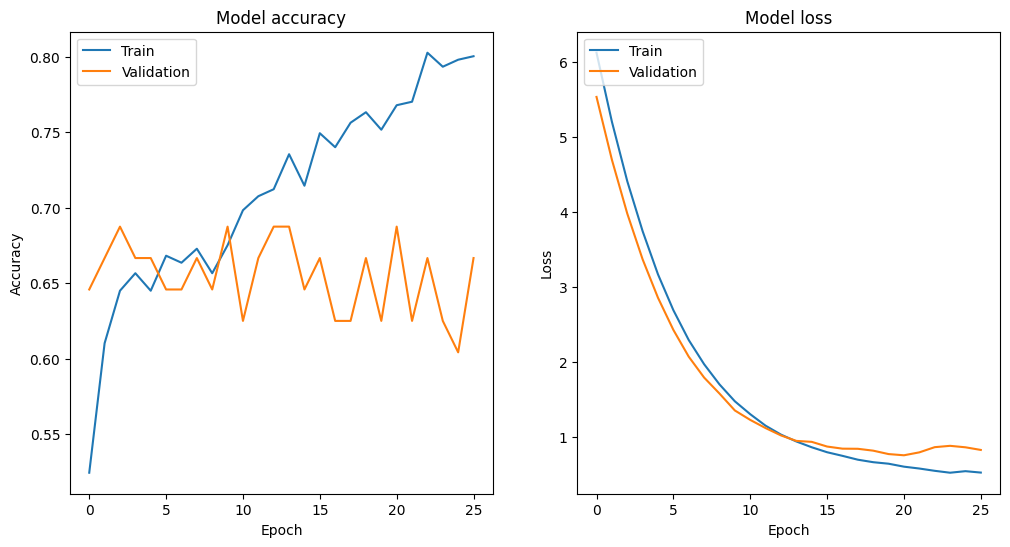

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6421 - loss: 0.7703
Test Loss: 0.8125826716423035
Test Accuracy: 0.6416666507720947


In [406]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# 5. Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)